# Multivariate analyses of tongue contours from ultrasound tongue

imaging

Stefano Coretta [](https://orcid.org/0000-0001-9627-5532) (University of Edinburgh)  
Georges Sakr [](https://orcid.org/0000-0003-3813-2669) (University of Edinburgh)  
April 8, 2025

In [ ]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

## Introduction

Ultrasound Tongue Imaging (UTI) is a non-invasive technique that allows researchers to image the shape of the tongue during speech at medium temporal resolution (30-100 frames per second, XXX). Typically, the midsagittal contour of the tongue is imaged, although 3D systems exist \[XXX\]. Recent developments in machine learning assisted image processing has enabled faster tracking of estimated points on the tongue contour ([A. Wrench and Balch-Tomes 2022](#ref-wrench2022)).

A. Wrench and Balch-Tomes ([2022](#ref-wrench2022)) have trained a DeepLabCut model to estimate and track specific flesh points on the tongue contour and anatomical landmarks as captured by UTI. The model estimates 11 “knots” from the vallecula to the tongue tip, plus three muscular-skeletal knots, the hyoid bone, the mandible base and and the mental spine where the short tendon attaches. See <a href="#fig-knots" class="quarto-xref">Figure 1</a> for a schematic illustration of the position of the tracked knots.

<figure id="fig-knots">
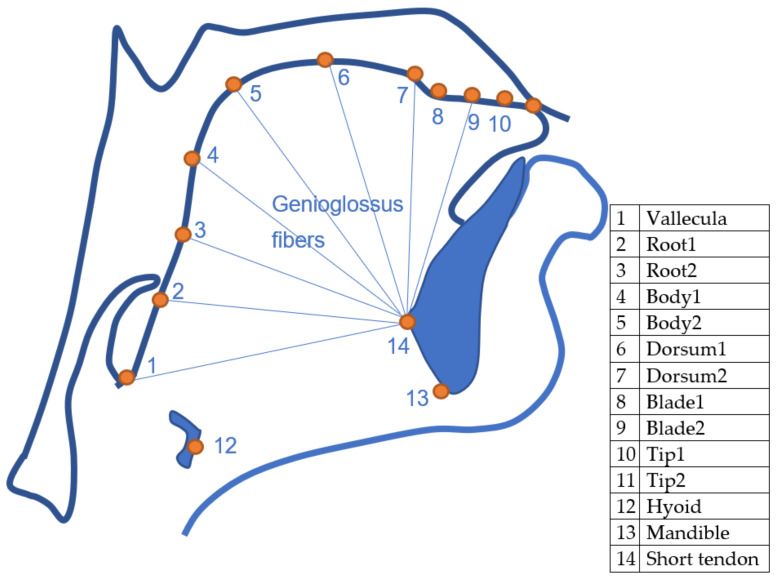
<figcaption>Figure 1: Schematic representation of the knots tracked by DeepLabCut. CC-BY Wrench and Balch-Tomes <span class="citation" data-cites="wrench2024">(<a href="#ref-wrench2024" role="doc-biblioref">A. A. Wrench 2024</a>)</span>.</figcaption>
</figure>

## GAM

Generalised additive models (GAMs) are an extension of generalised models that allow flexible modelling of non-linear effects ([Hastie and Tibshirani 1986](#ref-hastie1986); [Wood 2006](#ref-wood2006)). GAMs are built upon smoothing splines functions, the components of which are multiplied by estimated coefficients to reconstruct an arbitrary time-changing curve. For a thorough introduction to GAMs we refer the reader to ([Sóskuthy 2021b](#ref-soskuthy2017a), [2021a](#ref-soskuthy2021); [Pedersen et al. 2019](#ref-pedersen2019); [Wieling 2018](#ref-wieling2018)).

The data tracked by DeepLabCut consists of the position on the horizontal (*x*) and vertical (*y*) axes of the fourteen knots. In this tutorial, we will focus on modelling the tongue contour based on the 11 knots from the vallecula to the tongue tip. <a href="#fig-tongue" class="quarto-xref">Figure 2</a> illustrates the reconstructed tongue contour on the basis of the 11 knots: the shown tongue is from the offset of a vowel \[o\] followed by \[t\], uttered by a Polish speaker (see below for details on the data).

In [ ]:
dlc_voff_f <- readRDS("data/coretta2018/dlc_voff_f.rds")

dlc_voff_f |> 
  filter(speaker == "pl04", frame_id == 432) |> 
  ggplot(aes(X, Y, group = frame_id)) +
  geom_point() +
  geom_path() +
  coord_fixed() +
  labs(x = "X (mm)", y = "Y (mm)")

The same data is shown in <a href="#fig-tongue-xy" class="quarto-xref">Figure 3</a>, but in a different format. Instead of a Cartesian coordinate system of X and Y values, the plot has knot number on the *x*-axis and X/Y coordinates on the *y*-axis. The X/Y coordinates thus form “trajectories” along the knots. These trajectories are the ones that can be modelled using GAMs and Functional Principal Component Analysis (FPCA). In this section, we will illustrate GAMs applied to the X/Y trajectories along the knots and how we can reconstruct the tongue contour from the modelled trajectories. We will use data from two case studies of coarticulation: vowel consonant (VC) coarticulation based on C place in Italian and Polish, and consonantal articulation of plain vs emphatic consonants in Lebanese Arabic.

In [ ]:
dlc_voff_f |> 
  filter(speaker == "pl04", frame_id == 432) |> 
  dplyr::select(knot, X, Y) |> 
  pivot_longer(c(X,Y)) |> 
  ggplot(aes(knot + 1, value)) +
  geom_point() +
  geom_path() +
  facet_grid(rows = vars(name)) +
  scale_x_continuous(breaks = 1:11) +
  labs(x = "Knot", y = "Position (mm)")

### VC coarticulation

The data of the first case study, Coretta ([2018](#ref-coretta2018f)), comes from Coretta ([2020b](#ref-coretta2020b)) and have been discussed in Coretta ([2020a](#ref-coretta2020)) (the analysis concerned the position of the tongue root during the duration of vowels followed by voiceless or voiced stops; in this paper we focus on tongue contours at the vowel offset). The materials are /pVCV/ words embedded in a frame sentence (*Dico X lentamente* ‘I say X slowly’ in Italian and *Mówię X teraz* ‘I say X now’ in Polish). In the /pVCV/ words, C was /t, d, k, ɡ/ and V was /a, o, u/ (in each word, the two vowels where identical, so for example *pata, poto, putu*). The data analysed here is from 9 speakers of Italian and 6 speakers of Polish (other speakers were not included due to the difficulty in processing their data with DeepLabCut).

\[XXX Processing of data with DLC and filtering. Link to notebook\].

The following code chunk reads the filtered data. A sample of the data is shown in <a href="#tbl-dlc-voff" class="quarto-xref">Table 1</a>. <a href="#fig-voff" class="quarto-xref">Figure 4</a> shows the tongue contours for each individual speaker. It is possible to notice clusters of different contours, related to each of the vowels /a, o, u/. <a href="#fig-pl04" class="quarto-xref">Figure 5</a> zooms in on PL04 (Polish): the contours of each vowel are coloured separately, and two panels separate tongue contours taken at the offset of vowels followed by coronal (/t, d/) and velar stops (/k, ɡ/). Crucially, the variation in tongue shape at vowel offset (or closure onset) across vowels contexts is higher in the coronal than in the velar contexts. This is not surprising, giving the greater involvement of the tongue body and dorsum (the relevant articulators of vowel production) in velar than in coronal stops.

In [ ]:
dlc_voff_f <- readRDS("data/coretta2018/dlc_voff_f.rds")

In [ ]:
head(dlc_voff_f |> select(speaker, word, X, Y, knot, knot_label)) |> kable()

In [ ]:
dlc_voff_f |> 
  ggplot(aes(X_z, Y_z, group = frame_id)) +
  geom_path(alpha = 0.25) +
  coord_fixed() +
  facet_wrap(vars(speaker), ncol = 5)

In [ ]:
dlc_voff_f |> 
  filter(speaker == "pl04") |> 
  ggplot(aes(X_z, Y_z, group = frame_id, colour = vowel)) +
  geom_path(alpha = 0.5) +
  coord_fixed() +
  facet_grid(cols = vars(c2_place)) +
  labs(x = "X (z-scores)", "Y (z-scores)")

In [ ]:
library(mgcv)

Loading required package: nlme


Attaching package: 'nlme'

The following object is masked from 'package:dplyr':

    collapse

This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.

In [ ]:
frame_voff <- expand_grid(
  speaker = unique(dlc_voff_f$speaker),
  vow_place_lang = unique(dlc_voff_f$vow_place_lang),
  knot = seq(0, 10, by = 0.1)
) |> 
  mutate(
    vow_place = str_remove(vow_place_lang, "\\.Italian"),
    vow_place = str_remove(vow_place, "\\.Polish"),
  )

excl <- c(
  "s(knot,speaker):vow_placea.coronal",
  "s(knot,speaker):vow_placeo.coronal",
  "s(knot,speaker):vow_placeu.coronal",
  "s(knot,speaker):vow_placea.velar",
  "s(knot,speaker):vow_placeo.velar",
  "s(knot,speaker):vow_placeu.velar",
  "s.1(knot,speaker):vow_placea.coronal",
  "s.1(knot,speaker):vow_placeo.coronal",
  "s.1(knot,speaker):vow_placeu.coronal",
  "s.1(knot,speaker):vow_placea.velar",
  "s.1(knot,speaker):vow_placeo.velar",
  "s.1(knot,speaker):vow_placeu.velar"
)

voff_gam_p <- predict(voff_gam, frame_voff, se.fit = TRUE, exclude = excl) |>
  as.data.frame() |>
  as_tibble()
colnames(voff_gam_p) <- c("X", "Y", "X_se", "Y_se")

voff_gam_p <- bind_cols(frame_voff, voff_gam_p) |> 
  # pick any speaker, random effects have been removed
  filter(speaker == "it01") |> 
  mutate(
    X_lo = X - (1.96 * X_se),
    X_hi = X + (1.96 * X_se),
    Y_lo = Y - (1.96 * Y_se),
    Y_hi = Y + (1.96 * Y_se)
  ) |> 
  separate(vow_place_lang, c("vowel", "place", "language"))

In [ ]:
voff_gam_p |> 
  ggplot(aes(X, Y, colour = vowel)) +
  geom_point(alpha = 0.5) +
  facet_grid(cols = vars(place), rows = vars(language)) +
  coord_fixed() +
  labs(
    x = "X (z-scores)",
    y = "Y (z-scores)"
  )

In [ ]:
voff_gam_p |> 
  group_by(place, vowel, language) |> 
  mutate(
    Y_lo = ifelse(Y_lo > min(Y), Y_lo, NA),
    X_hi = ifelse(X_hi < max(X), X_hi, NA),
  ) |> 
  ggplot(aes(X, Y, colour = vowel)) +
  geom_errorbarh(aes(xmin = X_lo, xmax = X_hi), alpha = 0.5) +
  geom_errorbar(aes(ymin = Y_lo, ymax = Y_hi), alpha = 0.5) +
  geom_point(size = 1, alpha = 0.75) +
  scale_color_brewer(type = "qual", palette = "Dark2") +
  coord_fixed() +
  facet_grid(cols = vars(place), rows = vars(language)) +
  theme_light() +
  theme(legend.position = "bottom")

(`geom_errorbarh()`).

In [ ]:
frame_voff <- expand_grid(
  speaker = unique(dlc_voff_f$speaker),
  vow_place_lang = unique(dlc_voff_f$vow_place_lang),
  knot = seq(0, 10)
) |> 
  mutate(
    vow_place = str_remove(vow_place_lang, "\\.Italian"),
    vow_place = str_remove(vow_place, "\\.Polish"),
  )

pred_grid_a <- filter(
  frame_voff, vow_place_lang == "a.coronal.Italian",
  speaker == "it01"
)
pred_grid_b <- filter(
  frame_voff, vow_place_lang == "u.coronal.Italian",
  speaker == "it01"
)

pred_a <- predict.gam(voff_gam, pred_grid_a, type = "lpmatrix") |> 
  as_tibble() |> 
  mutate(
    across(starts_with("s(knot,speaker)"), ~0)
  ) |> 
  as.matrix()
pred_a[,1:870] <- 0

pred_b <- predict.gam(voff_gam, pred_grid_b, type = "lpmatrix") |> 
  as_tibble() |> 
  mutate(
    across(starts_with("s(knot,speaker)"), ~0)
  ) |> 
  as.matrix()
pred_b[,1:870] <- 0

pred_diff <- pred_a - pred_b
diff <- as.vector(pred_diff %*% stats::coef(voff_gam))

se <- sqrt(rowSums((pred_diff %*% stats::vcov(voff_gam)) * pred_diff))

diff_out <- pred_grid_a
diff_out$diff <- diff
diff_out$se <- se
diff_out$lower_ci <- diff - se * 1.96
diff_out$upper_ci <- diff + se * 1.96

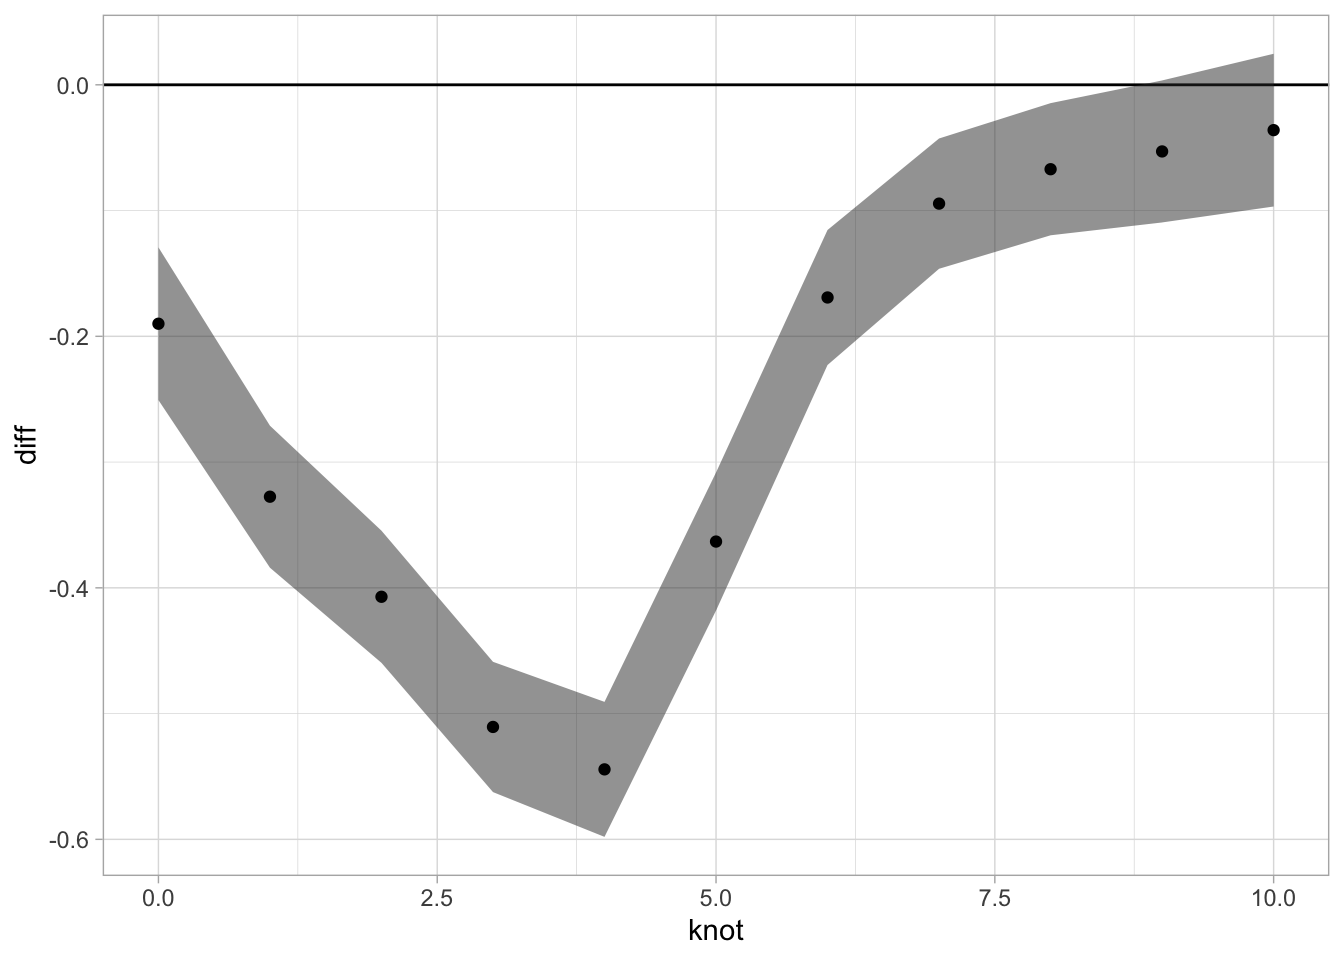

In [ ]:
diff_out |> 
  ggplot(aes(knot, diff)) +
  geom_hline(yintercept = 0) +
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci), alpha = 0.5) +
  geom_point()

### Emphaticness

In [ ]:
dlc_emph_f <- readRDS("data/sakr2025/dlc_emph_f.rds")

In [ ]:
library(mgcv)

fi <- "data/cache/emph_gam.rds"

if (file.exists(fi)) {
  emph_gam <- readRDS(fi)
} else {
  emph_gam <- gam(
    list(
      X_z ~ vow_emph +
        s(knot, by = vow_emph, k = 5) +
        s(knot, participant, by = vow_emph, bs = "fs", m = 1, k = 5),
      Y_z ~ vow_emph +
        s(knot, by = vow_emph, k = 5) +
        s(knot, participant, by = vow_emph, bs = "fs", m = 1, k = 5)
    ),
    data = dlc_emph_f,
    family = mvn(d = 2)
  )
  
  saveRDS(emph_gam, fi)
}

In [ ]:
frame_emph <- expand_grid(
  participant = unique(dlc_emph_f$participant),
  vow_emph = unique(dlc_emph_f$vow_emph),
  knot = seq(0, 10, by = 0.1)
)

excl <- c(
  "s(Knot,participant):vow_emphA.Emphatic",
  "s(Knot,participant):vow_emphE.Emphatic",
  "s(Knot,participant):vow_emphI.Emphatic",
  "s(Knot,participant):vow_emphO.Emphatic",
  "s(Knot,participant):vow_emphU.Emphatic",
  "s.1(Knot,participant):vow_emphA.Emphatic",
  "s.1(Knot,participant):vow_emphE.Emphatic",
  "s.1(Knot,participant):vow_emphI.Emphatic",
  "s.1(Knot,participant):vow_emphO.Emphatic",
  "s.1(Knot,participant):vow_emphU.Emphatic",
  "s(Knot,participant):vow_emphA.Plain",
  "s(Knot,participant):vow_emphE.Plain",
  "s(Knot,participant):vow_emphI.Plain",
  "s(Knot,participant):vow_emphO.Plain",
  "s(Knot,participant):vow_emphU.Plain",
  "s.1(Knot,participant):vow_emphA.Plain",
  "s.1(Knot,participant):vow_emphE.Plain",
  "s.1(Knot,participant):vow_emphI.Plain",
  "s.1(Knot,participant):vow_emphO.Plain",
  "s.1(Knot,participant):vow_emphU.Plain"
)

emph_gam_p <- predict(emph_gam, frame_emph, se.fit = TRUE, exclude = excl) |>
  as.data.frame() |>
  as_tibble()
colnames(emph_gam_p) <- c("X", "Y", "X_se", "Y_se")

emph_gam_p <- bind_cols(frame_emph, emph_gam_p) |> 
  # pick any speaker, random effects have been removed
  filter(participant == "Sak") |> 
  mutate(
    X_lo = X - (1.96 * X_se),
    X_hi = X + (1.96 * X_se),
    Y_lo = Y - (1.96 * Y_se),
    Y_hi = Y + (1.96 * Y_se)
  ) |> 
  separate(vow_emph, c("vowel", "emph"))

In [ ]:
emph_gam_p |> 
  ggplot(aes(X, Y, colour = emph)) +
  geom_point() +
  facet_grid(cols = vars(vowel)) +
  coord_fixed() +
  theme(legend.position = "bottom")

In [ ]:
emph_gam_p |> 
  ggplot(aes(X, Y, colour = emph)) +
  geom_errorbarh(aes(xmin = X_lo, xmax = X_hi), alpha = 0.25) +
  geom_errorbar(aes(ymin = Y_lo, ymax = Y_hi), alpha = 0.25) +
  geom_point(size = 1, alpha = 0.75) +
  scale_color_brewer(type = "qual", palette = "Dark2") +
  coord_fixed() +
  facet_grid(cols = vars(vowel)) +
  theme_light() +
  theme(legend.position = "bottom")

In [ ]:
emph_gam_p_2 <- predict(emph_gam, frame_emph, se.fit = TRUE) |>
  as.data.frame() |>
  as_tibble()
colnames(emph_gam_p_2) <- c("X", "Y", "X_se", "Y_se")

emph_gam_p_2 <- bind_cols(frame_emph, emph_gam_p_2) |>
  mutate(
    X_lo = X - (1.96 * X_se),
    X_hi = X + (1.96 * X_se),
    Y_lo = Y - (1.96 * Y_se),
    Y_hi = Y + (1.96 * Y_se)
  ) |> 
  separate(vow_emph, c("vowel", "emph"))

In [ ]:
emph_gam_p_2 |> 
  ggplot(aes(X, Y, colour = emph)) +
  geom_errorbarh(aes(xmin = X_lo, xmax = X_hi), alpha = 0.5) +
  geom_errorbar(aes(ymin = Y_lo, ymax = Y_hi), alpha = 0.5) +
  # geom_point() +
  facet_grid(rows = vars(participant), cols = vars(vowel)) +
  coord_fixed()

In [ ]:
frame_emph <- expand_grid(
  participant = unique(dlc_emph_f$participant),
  vow_emph = unique(dlc_emph_f$vow_emph),
  knot = 0:10
)

pred_grid_a <- filter(
  frame_emph, vow_emph == "E.plain",
  participant == "Sak"
)
pred_grid_b <- filter(
  frame_emph, vow_emph == "E.emphatic",
  participant == "Sak"
)

pred_a <- predict.gam(emph_gam, pred_grid_a, type = "lpmatrix") |> 
  as_tibble() |> 
  mutate(
    across(starts_with("s(knot,participant)"), ~0)
  ) |> 
  as.matrix()
# pred_a[,301:603] <- 0
pred_a[,1:300] <- 0

pred_b <- predict.gam(emph_gam, pred_grid_b, type = "lpmatrix") |> 
  as_tibble() |> 
  mutate(
    across(starts_with("s(knot,participant)"), ~0)
  ) |> 
  as.matrix()
# pred_b[,301:603] <- 0
pred_b[,1:300] <- 0

pred_diff <- pred_a - pred_b
diff <- as.vector(pred_diff %*% stats::coef(emph_gam))

se <- sqrt(rowSums((pred_diff %*% stats::vcov(emph_gam)) * pred_diff))

diff_out <- pred_grid_a
diff_out$diff <- diff
diff_out$se <- se
diff_out$lower_ci <- diff - se * 1.96
diff_out$upper_ci <- diff + se * 1.96

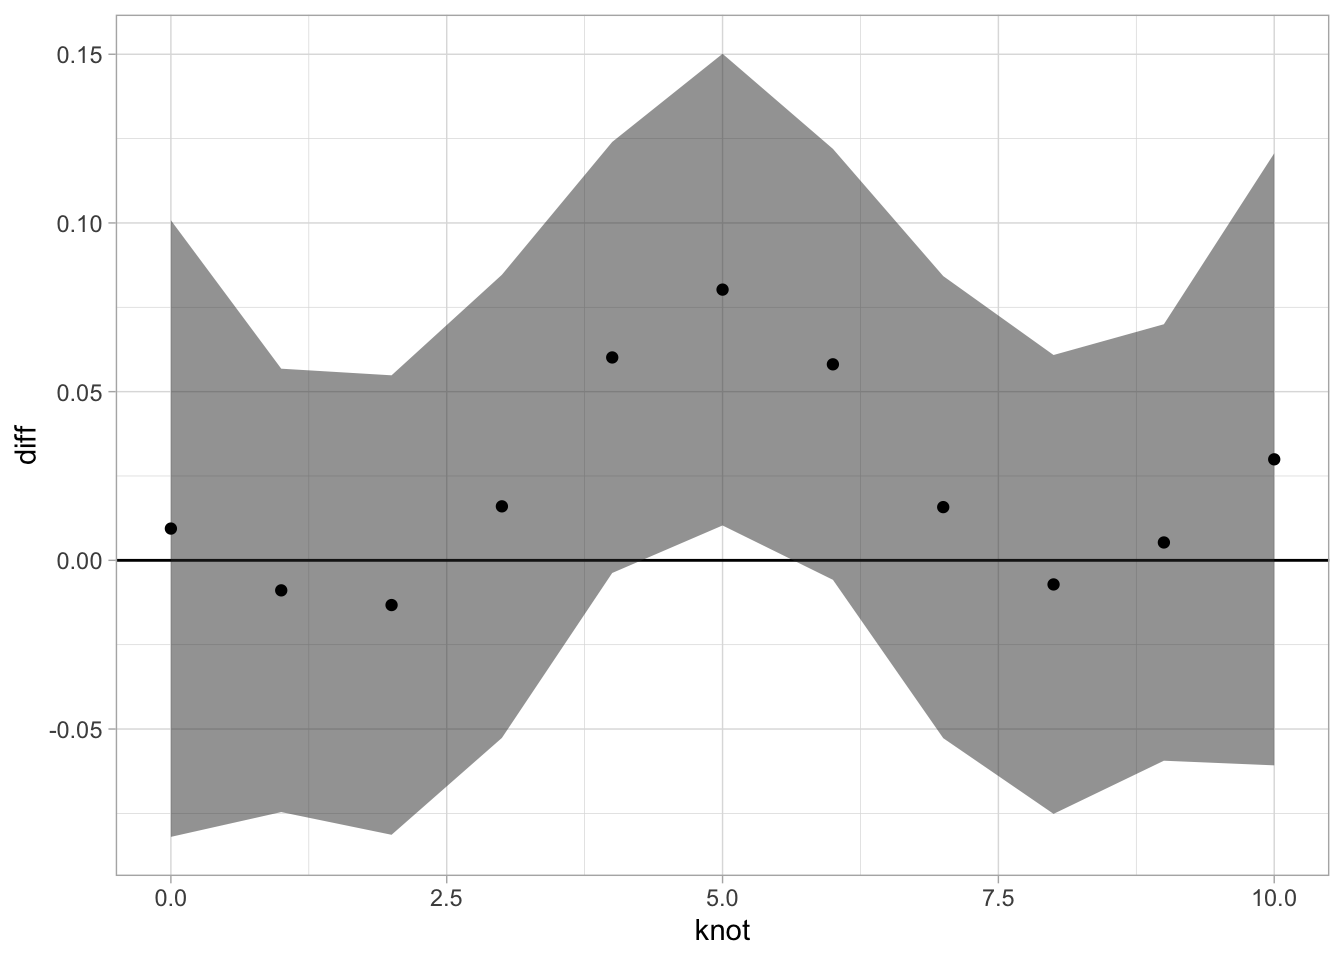

In [ ]:
diff_out |> 
  ggplot(aes(knot, diff)) +
  geom_hline(yintercept = 0) +
  geom_ribbon(aes(ymin = lower_ci, ymax = upper_ci), alpha = 0.5) +
  geom_point()

## FPCA

### VC coarticulation

We will apply Multivariate Functional Principal Component Analysis (MFPCA). The following code has been adapted from Gubian ([2024](#ref-gubian2024)). The packages below are needed to run MFPCA (except landmarkregUtils, they are available on CRAN).

In [ ]:
library(fda)

Loading required package: splines

Loading required package: fds

Loading required package: rainbow

Loading required package: MASS


Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: pcaPP

Loading required package: RCurl


Attaching package: 'RCurl'

The following object is masked from 'package:tidyr':

    complete

Loading required package: deSolve


Attaching package: 'fda'

The following object is masked from 'package:graphics':

    matplot


Attaching package: 'funData'

The following object is masked from 'package:ggplot2':

    ggplot

The following object is masked from 'package:stats':

    integrate

The format required to work through MFPCA is a “long” format with one column containing the coordinate labels (*x* or *y* coordinate) and another with the coordinate values. We can easily pivot the data with `pivot_longer()`. Note that we are using the *z*-scored coordinate values (`X_z` and `Y_z`). If you are not unsure about what the code in this section, it is always useful to inspect intermediate and final output.

In [ ]:
dlc_voff_long <- dlc_voff_f |> 
  # Select relevant columns
  dplyr::select(X_z, Y_z, frame_id, knot, vowel, c2_place, language, speaker) |> 
  # Pivot data to longer format. Saves coordinate labels to column `dim`
  pivot_longer(c(X_z, Y_z), names_to = "dim")

In the second step, we create a `multiFunData` object: this is a special type of list object, with the observations of the two coordinates (`X_z` and `Y_z`) as two matrices of dimension $N \cdot 11$, where $N$ is the number of tongue contours and $11$ is for the 11 knots returned by DLC. Three columns in the data are used to create the `multiFunData` object: one column with the id of each contour (in our data, `frame_id`), a time or series column (`knot`) and the column with the coordinate values (`value`).

In [ ]:
curves_fun_2d <- lapply(
  c("X_z", "Y_z"),
  function(y) {
    long2irregFunData(
      dlc_voff_long |> filter(dim == {{y}}),
      # Tongue contour ID
      id = "frame_id",
      # Knot column
      time = "knot",
      # X/Y coordinate values
      value = "value"
    ) |> 
    as.funData()
  }
) |> 
  multiFunData()

Once we have our `multFunData` object, we can use the `MFPCA()` function to compute an MFPCA. In this tutorial we will compute the first two PCs, but you can compute up to $K-1$ PCs where $K$ is the number of DLC knots in the data.

In [ ]:
# Number of PC to compute
n_pc <- 2

# Compute MFPCA
mfpca <- MFPCA(
  curves_fun_2d,
  M = n_pc,
  uniExpansions = list(list(type = "uFPCA"), list(type = "uFPCA"))
)

We can quickly calculate the proportion of explained variance of each PC with the following code. PC1 and PC2 together explain almost 100% of the variance in our data. The higher the variance explained, the better the variance patterns in the data are captured.

In [ ]:
# Proportion of explained variance
mfpca$values  / sum(mfpca$values)

[1] 0.7108713 0.2891287

The best way to assess the effect of the PC scores on the shape of the tongue contours is to plot the predicted tongue contours based on a set of representative PC scores. In order to be able to plot the predicted contours, we need to calculate them from the MFPCA object. Gubian suggests plotting predicted curves at score intervals based on fractions of the scores standard deviation. This is what the following code does.

In [ ]:
# Ge the PC score SD
sd_fun <- sqrt(mfpca$values)

# PC curves to be plotted
pc_curves <- expand_grid(
  PC = 1:n_pc,
  dim = 1:2,
  # Set the SD fraction, from -1 SD to +1 SD, with increments by 0.25
  sd_frac = seq(-1, 1, by = 0.25)
) |>
  group_by(PC, dim, sd_frac) |>
  # We can now calculate the predicted contour with funData2long1().
  # reframe() is needed because the funData2long1() function returns a data frame
  # the has more rows than the original.
  reframe(
    funData2long1(
      mfpca$meanFunction[[dim]] +
        sd_frac * sd_fun[PC] * mfpca$functions[[dim]][PC],
      time = "knot", value = "value"
    )
  ) |> 
  # We relabel the dimensions
  mutate(
    dim = factor(dim, levels = c(2, 1), labels = c('Y_z', 'X_z'))
  )

The created data frame `pc_curves` has the predicted values of the X and Y coordinates *along the knots*. This is the same structure as <a href="#fig-tongue-xy" class="quarto-xref">Figure 3</a>, with the knot number on the *x*-axis and the coordinates on the *y*-axis. Of course, what we are after is the X/Y plot of the tongue contours, rather than the knot/coordinate plot as needed to fit an MFPCA. For the sake of clarity, we first plot the predicted curves for X and Y separately. <a href="#fig-pc-curves" class="quarto-xref">Figure 11</a> shows these. The plot is composed of four panels: the top two are the predicted curves along knot number for the Y coordinates (based on PC1 in the left panel and PC2 in the right panel). Interpreting the effect of the PCs on the X and Y coordinates separately allows one to observe vertical (Y coordinate) and horizontal (X coordinate) differences in tongue position independently. However, note that the vector of muscle contractions in the tongue are not simply along a vertical/horizontal axis ([Honda 1996](#ref-honda1996); [A. A. Wrench 2024](#ref-wrench2024)). Looking at a full tongue contour (in an X/Y coordinates plot) will generally prove to be more straightforward.

In [ ]:
pc_curves |> 
  ggplot(aes(
    x = knot, y = value, group = sd_frac, color = sd_frac
  )) +
  geom_line() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_grid(
    cols = vars(PC), rows = vars(dim),
    scales = "free_y",
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  labs(color = expression(frac(s[k], sigma[k]))) +
  geom_line(
    data = pc_curves |> filter(sd_frac == 0),
    color = 'black', linewidth = 1.2
  )

In order to plot tongue contours in the X/Y coordinate system, we simply need to pivot the data to a wider format.

In [ ]:
pc_curves_wide <- pc_curves |> 
  pivot_wider(names_from = dim)

<a href="#fig-contours" class="quarto-xref">Figure 12</a> plots the predicted contours based on the the PC scores (specifically, fractions of the standard deviation of the PC scores). The *x* and *y*-axes correspond to the X and Y coordinates of the tongue contour, with the effect of PC1 in the left panel and the effect of PC2 in the right panel. A higher PC1 score (green lines in the left panel) suggest a lowering of the tongue body/dorsum and raising of the tongue tip. Since the data contains velar and coronal consonants, we take this to be capturing the velar/coronal place of articulation effect. A higher PC2 score (green lines in the right panel) corresponds to an overall higher tongue position. Considering that the back/central vowels /a, o, u/ are included in this data set, we take PC2 to be related with the effect of vowel on the tongue shape at closure onset.

In [ ]:
pc_curves_wide |> 
  ggplot(aes(x = X_z, y = Y_z, group = sd_frac, color = sd_frac)) +
  geom_path() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_wrap(
    vars(PC),
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  coord_fixed()

Given the patterns in <a href="#fig-contours" class="quarto-xref">Figure 12</a>, we can expect to see differences in PC2 scores based on the vowel if there is VC coarticulation. We can obtain the PC scores of each observation in the data with the following code.

In [ ]:
pc_scores <- mfpca$scores |>
  `colnames<-`(paste0("PC", 1:n_pc)) |>
  as_tibble() |>
  bind_cols(dlc_voff_long |> distinct(frame_id, vowel, c2_place, language))

<a href="#fig-pc-scores" class="quarto-xref">Figure 13</a> plots PC scores by language (rows), consonant place (columns) and vowel (colour). Both in Italian and Polish, we can observe a clear coarticulatory effect of /u/ on the production of coronal stops (and perhaps minor differences in /a/ vs /o/). On the other hand, the effect of vowel in velar stops seems to be minimal, again in both languages. This is not entirely surprising, since while coronal stops allow for adjustments of (and coarticulatory effect on) the tongue body, velar stops do not since it is precisely the tongue body/dorsum that is raised to produce the velar closure.

In [ ]:
pc_scores |> 
  filter(PC2 < 0.5) |>
  ggplot(aes(x = PC1, y = PC2, color = vowel)) +
  geom_point() +
  stat_ellipse() +
  facet_grid(cols = vars(c2_place), rows = vars(language)) +
  scale_color_brewer(palette = "Dark2")

Once one has established which patterns each PC is capturing, PC scores can be submitted to further statistical modelling, like for example regression models where the PC scores are outcome variables and several predictors are include to assess possible differences in PC scores.

### Emphaticness

In [ ]:
dlc_emph_long <- dlc_emph_f |> 
  pivot_longer(c(X_z, Y_z), names_to = "dim") |> 
  group_by(dim, participant) |> 
  mutate(
    value = (value - mean(value)) / sd(value)
  ) |> 
  ungroup()

In [ ]:
# build a multiFunData object
curves_fun_2d <- lapply(
  c("X_z", "Y_z"),
  function(y) {
    long2irregFunData(
      dlc_emph_long |> filter(dim == {{y}}),
      id = "frame_id",
      time = "knot",
      value = "value"
    ) |> 
    as.funData()
  }
) |> 
  multiFunData()

In [ ]:
# Compute FPCA
n_pc <- 2
mfpca <- MFPCA(
  curves_fun_2d,
  M = n_pc,
  uniExpansions = list(list(type = "uFPCA"), list(type = "uFPCA"))
)

In [ ]:
# Proportion of explained variance
mfpca$values  / sum(mfpca$values)

[1] 0.7309506 0.2690494

In [ ]:
# scores st. dev.
sd_fun <- sqrt(mfpca$values)

# PC curves to be plotted
pc_curves <- expand_grid(
  PC = 1:n_pc,
  dim = 1:2, 
  sd_frac = seq(-1, 1, by = 0.25)
) |> 
  group_by(PC, dim, sd_frac) |> 
  reframe(
    funData2long1(
      mfpca$meanFunction[[dim]] +
        sd_frac * sd_fun[PC] * mfpca$functions[[dim]][PC],
      time = "knot", value = "value"
    )
  ) |> 
  mutate(
    dim = factor(dim, levels = c(2,1), labels = c('Y_z', 'X_z'))
  )

In [ ]:
pc_curves |> 
  ggplot(aes(
    x = knot, y = value, group = sd_frac, color = sd_frac
  )) +
  geom_line() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_grid(
    cols = vars(PC), rows = vars(dim),
    scales = "free_y",
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  labs(color = expression(frac(s[k], sigma[k]))) +
  geom_line(
    data = pc_curves |> filter(sd_frac == 0),
    color = 'black', linewidth = 1.2
  )

In [ ]:
pc_curves_wide <- pc_curves |> 
  pivot_wider(names_from = dim)

In [ ]:
pc_curves_wide |> 
  ggplot(aes(x = X_z, y = Y_z, group = sd_frac, color = sd_frac)) +
  geom_path() +
  scale_color_gradient2(
    low = "#762a83", mid = "grey", high = "#1b7837",
    breaks = c(-1, 0 , 1)
  ) +
  facet_wrap(
    vars(PC),
    labeller = labeller(PC = ~str_glue("PC{.x}"))
  ) +
  coord_fixed()

In [ ]:
# collect PC scores
pc_scores <- mfpca$scores |>
  `colnames<-`( paste0("PC", 1:n_pc)) |>
  as_tibble() |>
  bind_cols(dlc_emph_long |> distinct(frame_id, emph, vowel, participant))

In [ ]:
pc_scores |> 
  ggplot(aes(x = PC1, y = PC2, colour = emph, label = vowel)) +
  geom_point(alpha = 0.5) +
  scale_color_brewer(palette = "Dark2") +
  stat_ellipse() +
  facet_grid(cols = vars(participant), rows = vars(vowel))

In [ ]:
pc_scores |> 
  ggplot(aes(vowel, PC1, colour = emph)) +
  geom_jitter(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.25) +
  scale_color_brewer(palette = "Dark2") +
    facet_wrap(vars(participant))

In [ ]:
pc_scores |> 
  ggplot(aes(vowel, PC2, colour = emph)) +
  geom_jitter(position = position_jitterdodge(jitter.width = 0.2), alpha = 0.25) +
  scale_color_brewer(palette = "Dark2") +
    facet_wrap(vars(participant))

Coretta, Stefano. 2018. “An Exploratory Study of the Voicing Effect in Italian and Polish \[Data V1.0.0\].” <https://doi.org/10.17605/OSF.IO/8ZHKU>.

———. 2020a. “Longer Vowel Duration Correlates with Greater Tongue Root Advancement at Vowel Offset: Acoustic and Articulatory Data from Italian and Polish.” *The Journal of the Acoustical Society of America* 147: 245259. <https://doi.org/10.1121/10.0000556>.

———. 2020b. “Vowel Duration and Consonant Voicing: A Production Study.” PhD thesis.

Gubian, Michele. 2024. *Workshop on Functional PCA for Phonetics and Prosody*. <https://github.com/uasolo/FPCA-phonetics-workshop>.

Hastie, Trevor, and Robert Tibshirani. 1986. “Generalized Additive Models.” *Statistical Science* 1 (3): 297310. <https://doi.org/10.1201/9780203753781-6>.

Honda, Kiyoshi. 1996. “Organization of Tongue Articulation for Vowels.” *Journal of Phonetics* 24 (1): 3952. <https://doi.org/10.1006/jpho.1996.0004>.

Pedersen, Eric J., David L. Miller, Gavin L. Simpson, and Noam Ross. 2019. “Hierarchical Generalized Additive Models in Ecology: An Introduction with Mgcv.” *PeerJ* 7: e6876. <https://doi.org/10.7717/peerj.6876>.

Sóskuthy, Márton. 2021a. “Evaluating Generalised Additive Mixed Modelling Strategies for Dynamic Speech Analysis.” *Journal of Phonetics* 84: 101017. <https://doi.org/10.1016/j.wocn.2020.101017>.

———. 2021b. “Generalised Additive Mixed Models for Dynamic Analysis in Linguistics: A Practical Introduction.” <https://doi.org/10.48550/arXiv.1703.05339>.

Wieling, Martijn. 2018. “Analyzing Dynamic Phonetic Data Using Generalized Additive Mixed Modeling: A Tutorial Focusing on Articulatory Differences Between L1 and L2 Speakers of English.” *Journal of Phonetics* 70: 86116. <https://doi.org/10.1016/j.wocn.2018.03.002>.

Wood, Simon. 2006. *Generalized Additive Models: An Introduction with r*. CRC Press.

Wrench, Alan A. 2024. “The Compartmental Tongue.” *Journal of Speech, Language, and Hearing Research* 67 (10S): 38873913. <https://doi.org/10.1044/2024_jslhr-23-00125>.

Wrench, Alan, and Jonathan Balch-Tomes. 2022. “Beyond the Edge: Markerless Pose Estimation of Speech Articulators from Ultrasound and Camera Images Using DeepLabCut.” *Sensors* 22 (3): 1133. <https://doi.org/10.3390/s22031133>.